In [1]:
from mimic.utilities.utilities import *

from mimic.model_infer import *
from mimic.model_simulate import *
import random, pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

set_all_seeds(1234)

## Simulate some time course data and perform ridge regression as in Stein et al. 2013
We have coded up the Stein model and ridge regression without the perturbation term (Ridge1) and with a single perturbation (Ridge 2). <br>
Ridge regression is designed to cause shrinkage to prevent overfitting but it isn't used for variable selection. 

In [2]:
# read in pickled simulated parameters, mu, M, epsilon
num_species = 5
with open("params-s5.pkl", "rb") as f:
    params = pickle.load(f)
M = params["M"]
mu = params["mu"]
epsilon = params["epsilon"]

### Single time course

n: 495, p: 30
minimum found: a0/a1/error: 0.06951927961775606 0.0003359818286283781 0.09243838333584196
unconstrained error        : 0.09410680457755412
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': [3.3157941477475106, 1.1358652199555763, 6.5906612581158015, 0.4486792830393824, 11.931612813620859], 'M': [[-0.2862510713026154, -0.1257991141542263, 0.08113516895856066, 0.08414040068359796, -0.03807194760576493], [-0.1056043834481386, -0.15602118339936055, 0.0629172250459078, 0.087503680644339, 0.004720183949899592], [0.16670352015194823, 0.06585148661527107, -0.5615754403693245, -0.045481327732655785, -0.23483611594052078], [0.05981786866709626, 0.04728063227894097, -0.0221558627691536, -0.04024500513830276, -0.017414462757074034], [-0.30534309593324593, -0.16854017733096782, -0.3109269559792125, 0.11255925665980726, -0.6402447766111194]], 'epsilon': array([], shape=(5, 0), dtype=float64)}
mu_hat/mu:
[ 3.31579415  1.13586522  6.59066126  0.44867928 11.93161

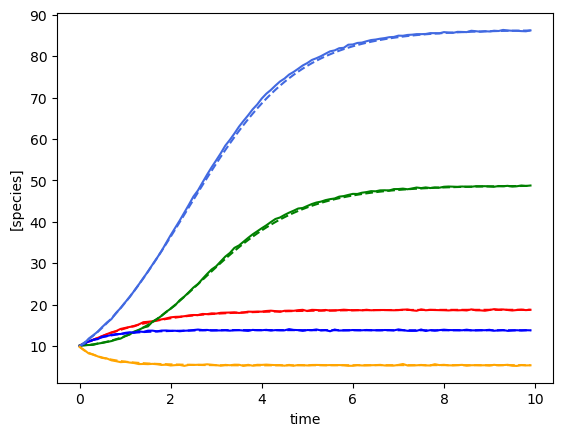

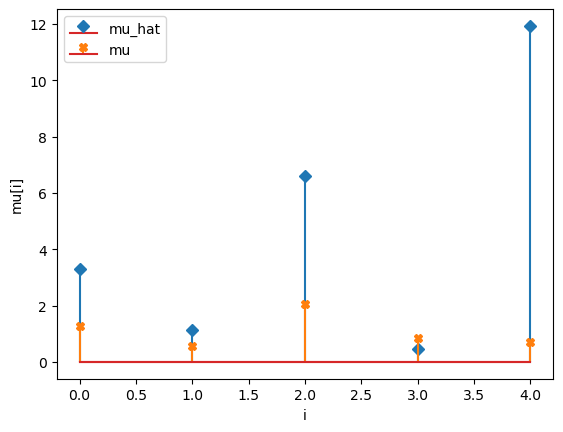

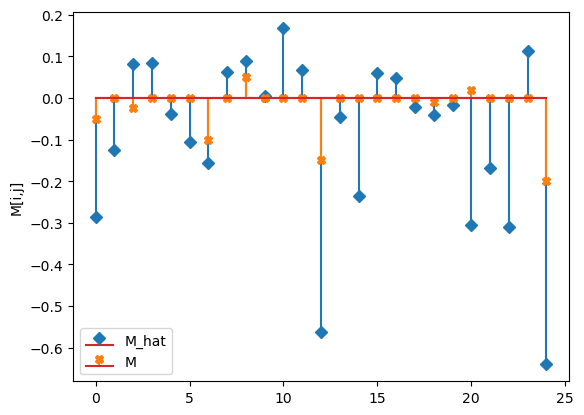

In [3]:
# In this example n >> p and it it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

# read in data
data = pd.read_csv("data-s5-r1.csv")
yobs = data.iloc[:, 1:num_species + 1].values
times = data.iloc[:, 0].values
init_species = data.iloc[0, 1:num_species + 1].values

# linearise
X, F = linearize_time_course_16S(yobs, times)
print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0, a1)

predictor = sim_gLV(num_species=num_species,
                     M=M_h,
                     mu=mu_h)
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

# plot comparison of simulated and predicted timeseries
plot_fit_gLV(yobs, yobs_h, times)

# compare fitted with simulated parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))

### Multiple time course

(3, 100, 5)
[28.88248428 46.93130458 16.82105576 38.67933238 44.87209099]
minimum found: a0/a1/error: 14.38449888287663 0.0003359818286283781 0.09087441492461755
unconstrained error        : 0.0936265529922547
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': [1.3076182447128843, 0.7007870846514805, 1.7323181185493013, 0.939152846366909, 0.9463731954681975], 'M': [[-0.0528074534677343, 0.001594857905254321, -0.023725635373657683, -0.0009517313144397077, 0.001830545423415042], [-0.0013618603770018112, -0.0891706551444027, -0.010231789595595675, 0.04381396766772916, 0.005217705861086053], [-0.0017353530629105052, 0.0014706768672481108, -0.12421732070904623, -0.0006263765828428136, -0.0008487509975821927], [-0.0016746411786483506, 0.00014241803611425574, -0.004432583920997324, -0.009960264949600228, 0.0010646583798767928], [-0.0007870513610939156, 0.007022121413914562, -0.022713024253004477, -0.0021456346113835068, -0.14330117795700836]], 'epsilon': array([], sha

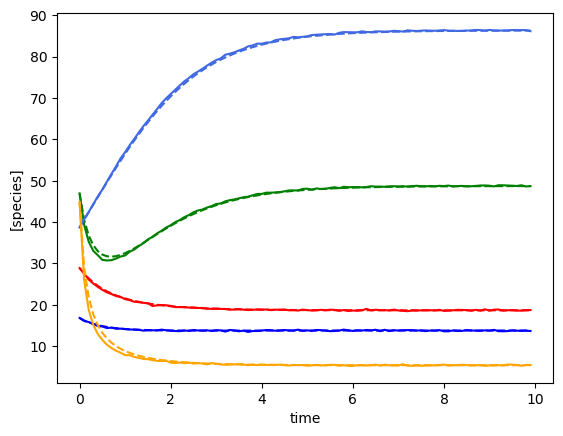

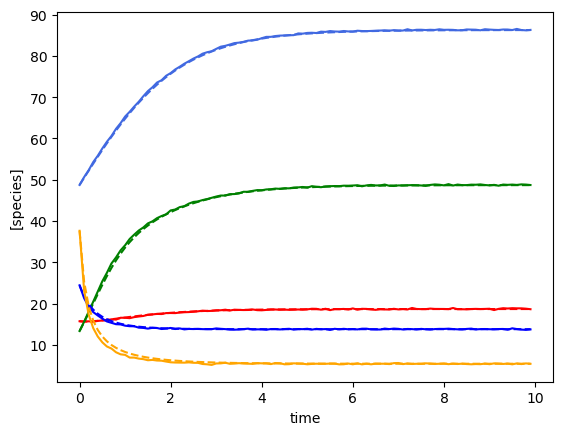

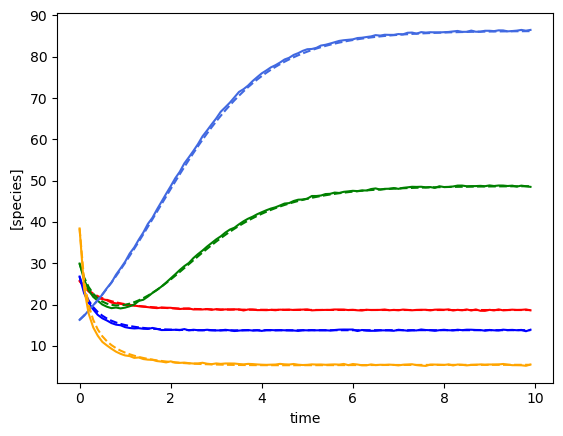

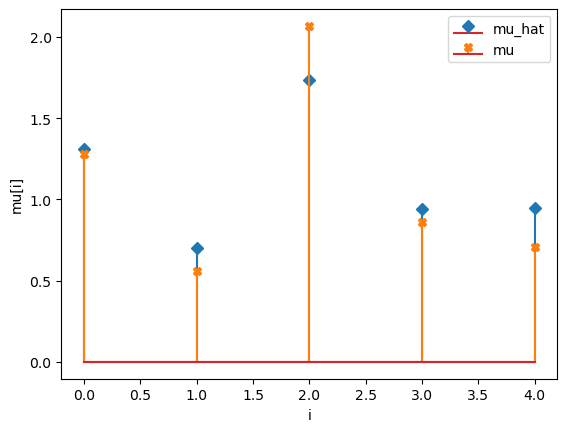

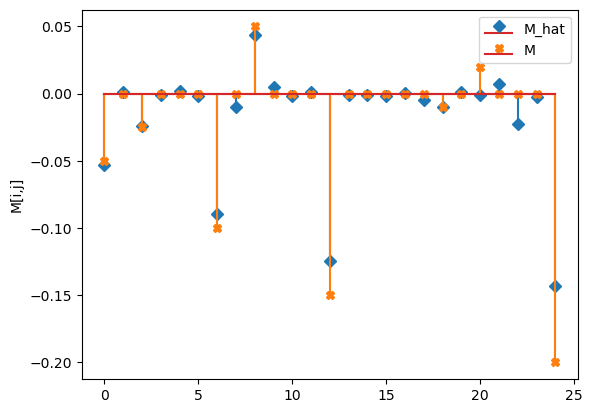

In [4]:
num_timecourses = 3
data = pd.read_csv("data-s5-r3.csv")
times = data.iloc[:, 0].values

yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3])
print(ryobs.shape)
print(ryobs[0,0,:])

X = np.array([], dtype=np.double).reshape(0, num_species+1)
F = np.array([], dtype=np.double).reshape(0, num_species)

for timecourse_idx in range(num_timecourses):
    Xs, Fs = linearize_time_course_16S(ryobs[timecourse_idx], times)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])

a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0=a0, a1=a1)
predictor = sim_gLV(num_species=num_species, M=M_h, mu=mu_h)

# plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=ryobs[timecourse_idx,0,:])
    plot_fit_gLV(ryobs[timecourse_idx], yobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu, mu_h), M=(M, M_h))


### Multiple time course including perturbations

minimum found: a0/a1/a2/error: 10.0 0.0001 0.0001 0.0914324042865548
unconstrained error        : 0.09270338174666316
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': [1.2863988090747316, 0.6349676883905023, 1.590512329658455, 0.8568035807250877, -0.016727314447421825], 'M': [[-0.049964976547379344, 0.004333538059607708, -0.02533085558525459, -0.002591104445108874, 0.0015663816233878972], [-0.001310470815665419, -0.08846932834060041, -0.005316559839246664, 0.0434457104621005, 0.004470070017733807], [0.0023794122645523076, -0.0014698840540907955, -0.12128135376689766, 0.001250251585021451, 0.0003352053411325288], [-0.00042459315571838786, 0.001105895127148893, -0.00018836939675936047, -0.010422356778636947, -0.00014720387093901388], [0.02908321689728509, -0.01945358863129413, 0.009006279777589768, 0.013126538655066678, -0.1541928175059054]], 'epsilon': [array([0.28721011]), array([-0.97886567]), array([0.28782729]), array([-0.96438316]), array([0.29924525])]}


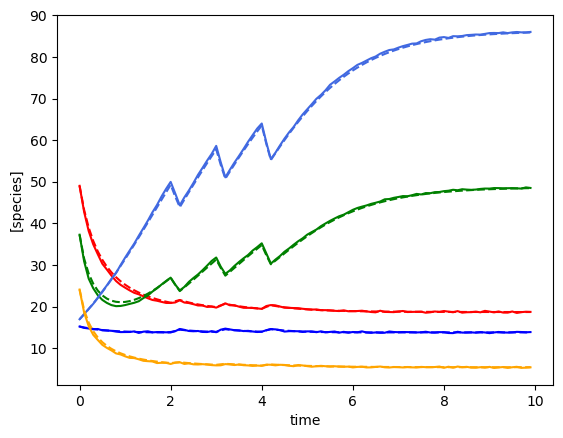

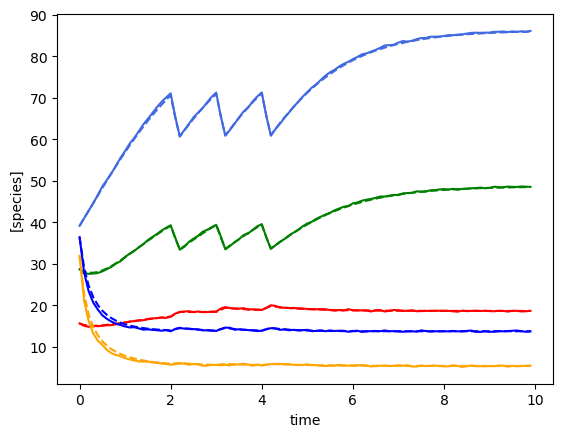

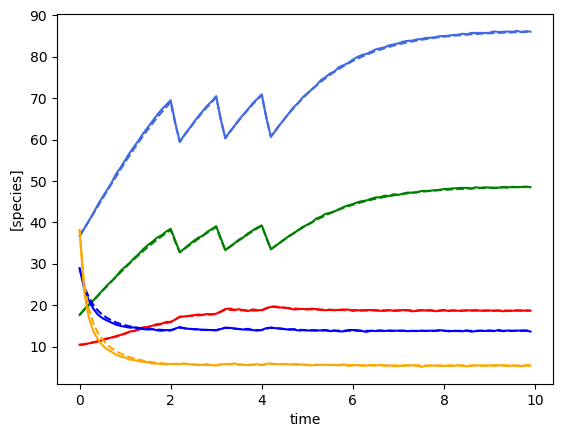

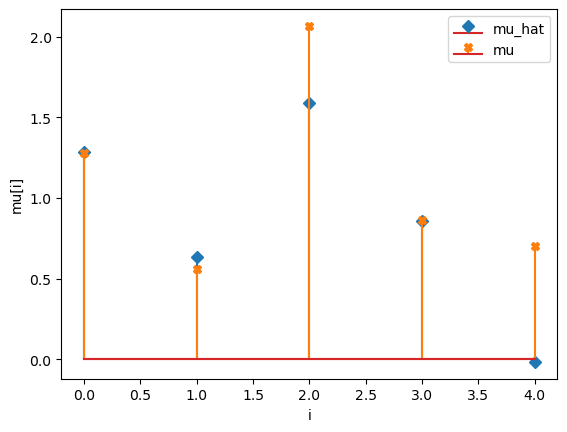

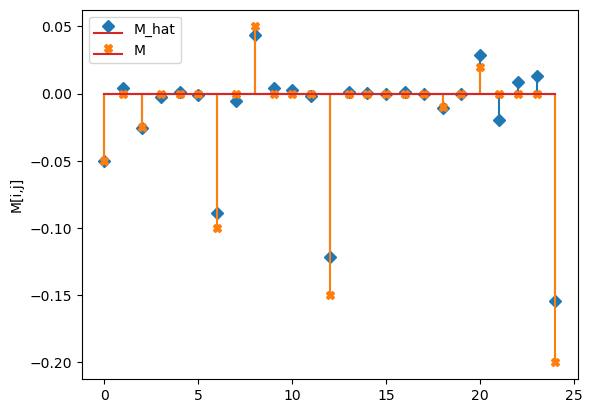

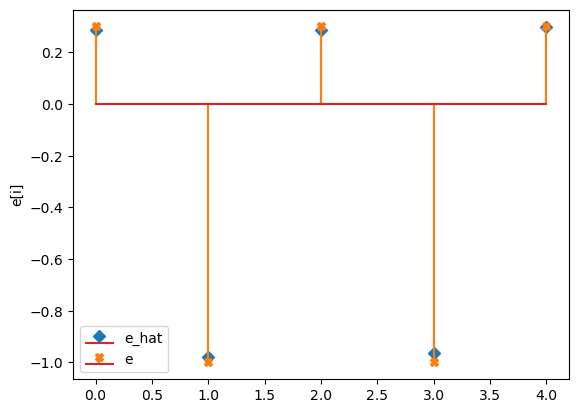

In [5]:
num_timecourses = 3
data = pd.read_csv("data-s5-r3-p1.csv")
times = data.iloc[:, 0].values

yobs_1 = data.iloc[:, 1:(num_species+1)].values
yobs_2 = data.iloc[:, (num_species+1):(2*num_species+1)].values
yobs_3 = data.iloc[:, (2*num_species+1):(3*num_species+1)].values
ryobs = np.array([yobs_1, yobs_2, yobs_3])

# create the perturbation signal
def pert_fn(t):
    if 2.0 <= t < 2.2 or 3.0 <= t < 3.2 or 4.0 <= t < 4.2:
        return np.array([1])
    else: 
        return np.array([0])

u = np.array([pert_fn(t)[0] for t in times])
u = u.astype(int)

X = np.array([], dtype=np.double).reshape(0, num_species+2)
F = np.array([], dtype=np.double).reshape(0, num_species)

for timecourse_idx in range(num_timecourses):
    Xs, Fs = linearize_time_course_16S_u(ryobs[timecourse_idx], times, u)
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])

a0, a1, a2 = fit_alpha_Ridge2(X, F, num_species=num_species, num_pert=1, n_a0=10, n_a1=10, n_a2=10)

# do final fit
mu_h, M_h, e_h = do_final_fit_Ridge2(X, F, num_species=num_species, num_pert=1, a0=a0, a1=a1, a2=a2)

predictor = sim_gLV(num_species=num_species,
                    num_perturbations=1,
                    M=M_h,
                    mu=mu_h,
                    epsilon=e_h,
                    )

# plot comparison of simulated and predicted timeseries
for timecourse_idx in range(num_timecourses):
    yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=ryobs[timecourse_idx,0,:], u=pert_fn)
    plot_fit_gLV(ryobs[timecourse_idx], yobs_h, times)

compare_params(mu=(mu, mu_h), M=(M, M_h), e=(epsilon, e_h))